# 準備

In [1]:
!pip install scipy

In [2]:
# -*- coding: utf-8 -*-
"""
reaction-diffusion-textures.ipynb (PyTorch Version)

This is a faithful PyTorch conversion of the original TensorFlow notebook:
https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/reaction_diffusion_textures.ipynb

* Project page: https://selforglive.github.io/alife_rd_textures/
* Paper: https://selforglive.github.io/alife_rd_textures/ALIFE_Reaction_Diffusion.pdf
"""

#@title Imports and Notebook Utilities
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
from scipy import ndimage

from tqdm import tnrange

# --- PyTorch Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import vgg16, VGG16_Weights

from IPython.display import Image, HTML, clear_output
import tqdm

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

error: XDG_RUNTIME_DIR not set in the environment.
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evalu

In [3]:

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    r = requests.get(url)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_tmp.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_tmp.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

class LoopWriter(VideoWriter):
  def __init__(self, *a, **kw):
    super().__init__(*a, **kw)
    self._intro = []
    self._outro = []
    self.fade_len = int(kw.get('fade_len', 1.0)*self.params['fps'])

  def add(self, img):
    if len(self._intro) < self.fade_len:
      self._intro.append(img)
      return
    self._outro.append(img)
    if len(self._outro) > self.fade_len:
      super().add(self._outro.pop(0))

  def close(self):
    for t in np.linspace(0, 1, len(self._intro)):
      img = self._intro.pop(0)*t + self._outro.pop(0)*(1.0-t)
      super().add(img)
    super().close()

if torch.cuda.is_available():
    !nvidia-smi -L

GPU 0: NVIDIA H100 PCIe (UUID: GPU-a5f9f975-135a-f61b-e158-a6c099388a66)


In [5]:
!wget https://github.com/google-research/self-organising-systems/raw/master/assets/reaction_diffusion_textures/targets.zip && unzip -o targets.zip

--2025-06-09 10:55:19--  https://github.com/google-research/self-organising-systems/raw/master/assets/reaction_diffusion_textures/targets.zip
Resolving proxy11.omu.ac.jp (proxy11.omu.ac.jp)... 172.29.0.11
Connecting to proxy11.omu.ac.jp (proxy11.omu.ac.jp)|172.29.0.11|:8080... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google-research/self-organising-systems/master/assets/reaction_diffusion_textures/targets.zip [following]
--2025-06-09 10:55:20--  https://raw.githubusercontent.com/google-research/self-organising-systems/master/assets/reaction_diffusion_textures/targets.zip
Connecting to proxy11.omu.ac.jp (proxy11.omu.ac.jp)|172.29.0.11|:8080... connected.
Proxy request sent, awaiting response... 200 OK
Length: 63479 (62K) [application/zip]
Saving to: ‘targets.zip.2’

targets.zip.2       100%[===================>]  61.99K  --.-KB/s    in 0.002s  

2025-06-09 10:55:20 (28.8 MB/s) - ‘targets.zip.2’ saved [63479/63479]

Archive

# モデル

In [ ]:
#@title RD Model definition {vertical-output: true}
from scipy.ndimage.filters import gaussian_filter

# Number of grid "chemical" channels
CHN = 34

def seed_f(n, sz=96, spot_prob=0.005, spread=3.0):
  """
  拡散反応モデルの初期状態を生成する関数。
  
  Parameters:
    n (int): 生成する初期状態の数。
    sz (int): 各初期状態のサイズ（高さと幅）。
    spot_prob (float): スポットが存在する確率。
    spread (float): スポットの広がり具合。
    
  Returns:
    np.ndarray: 生成された初期状態の配列。形状は (n, sz, sz, CHN)。
    
  生成された初期状態は、各ピクセルに対してランダムなスポットが配置され、ガウスフィルタで平滑化されている。
  """
  x = np.floor(np.random.rand(n, sz, sz, 1)+spot_prob)
  x = gaussian_filter(x, [0.0, spread, spread, 0.0], mode='wrap')
  x = x*spread**2
  x = np.repeat(x, 3, -1)
  # Pad to CHN channels
  pad_width = [(0, 0)] * 3 + [(0, CHN - x.shape[-1])]
  x = np.pad(x, pad_width, mode='constant').astype(np.float32)
  return cpm_reset(x) # 細胞IDとターゲットを初期化

def cpm_reset(x):
  """
  チャンネル0を細胞IDとする。
  チャンネル1を細胞のtargetとする。
  初期細胞を配置する。
  
  Parameters:
    x (np.ndarray): 入力配列。形状は (N, H, W, C)。
    
  Returns:
    np.ndarray: 細胞IDが設定された配列。形状は (N, H, W, C)。
  """
  
  if isinstance(x, torch.Tensor):
    x = x.detach().cpu().numpy()
    
  cell_num = 0 # 細胞数
  center = x.shape[1] // 2 # 中心位置
  
  x[:, :, :, 0:2] = 0.0
  for i in range(-1, 2):
    for j in range(-1, 2):
      cell_num += 1
      x[:, center+i*3, center+j*3, 0] = cell_num # 細胞IDを設定
  
  return x, cell_num
  
def to_rgb(x):
  # If x is a torch tensor, convert to numpy
  if isinstance(x, torch.Tensor):
    x = x.detach().cpu().numpy()
  return x[...,:3]+0.5

# Note: In PyTorch, convolutions expect (N, C, H, W)
# We handle this by permuting dimensions inside the model
def laplacian(x):
  """
  拡散項
  
  Parameters:
    x (torch.Tensor): 入力テンソル。形状は (N, C, H, W)。
    
  Returns:
    torch.Tensor: ラプラシアンフィルタを適用したテンソル。形状は (N, C, H, W)。
    
  """
  lap_k = np.float32([[1, 2, 1], [2, 4-16, 2], [1, 2, 1]]) / 16.0
  lap_k = np.expand_dims(lap_k, (0, 1))
  lap_k = np.repeat(lap_k, x.shape[1], axis=0) # Repeat for each channel
  kernel = torch.from_numpy(lap_k).to(x.device)

  # Pad for circular boundary conditions
  x = F.pad(x, (1, 1, 1, 1), 'circular')
  # Apply depthwise convolution
  return F.conv2d(x, kernel, groups=x.shape[1])

class CA(nn.Module):
  """反応拡散モデルのニューラルネットワーク。"""
  def __init__(self, chn=CHN, in_chn = None):
    super().__init__()
    
    self.in_chn = in_chn if in_chn is not None else chn
    
    self.w1 = nn.Conv2d(in_chn, 128, 1)
    self.w2 = nn.Conv2d(128, chn, 1, bias=False)

    with torch.no_grad():
        # TensorFlowのConv2Dのデフォルト(Glorot Uniform)に合わせてw1を初期化
        nn.init.xavier_uniform_(self.w1.weight)
        # TensorFlowのデフォルトに合わせてバイアスをゼロで初期化
        nn.init.zeros_(self.w1.bias)
        # w2の重みをゼロで初期化
        self.w2.weight.zero_()

    diff_coef = torch.tensor([0.125, 0.25, 0.5, 1.0], device=device).repeat(chn//4)
    self.register_buffer('diff_coef', diff_coef.view(1, chn, 1, 1))

  def get_giff_coef(self):
    return self.diff_coef

  def forward(self, x, r=1.0, d=1.0):
    # Ensure x is a tensor and on the correct device
    if not isinstance(x, torch.Tensor):
        x = torch.from_numpy(x).to(device)

    # Permute from (N, H, W, C) to (N, C, H, W)
    x = x.permute(0, 3, 1, 2)

    diff = laplacian(x) * self.get_giff_coef()
    y = self.w1(x)
    y = y * torch.sigmoid(y * 5.0)
    react = self.w2(y)

    x = x + diff * d + react * r

    # Permute back to (N, H, W, C)
    return x.permute(0, 2, 3, 1)



  def get_giff_coef(self):
    return self.diff_coef

  def forward(self, x, r=1.0, d=1.0):
    # Ensure x is a tensor and on the correct device
    if not isinstance(x, torch.Tensor):
        x = torch.from_numpy(x).to(device)

    # Permute from (N, H, W, C) to (N, C, H, W)
    x = x.permute(0, 3, 1, 2)

    diff = laplacian(x) * self.get_giff_coef()
    y = self.w1(x)
    y = y * torch.sigmoid(y * 5.0)
    react = self.w2(y)

    x = x + diff * d + react * r

    # Permute back to (N, H, W, C)
    return x.permute(0, 2, 3, 1)
  
  def __init__(self, chn=CHN, _slice = None):
    
    super().__init__()
    
  def forward(self, x, r=1.0, d=1.0):
    out = super().forward(x, r, d)
    if self._slice is not None:
      x[..., self._slice] = out[..., self._slice]
    return x

ca = CA().to(device)
param_n = sum(p.numel() for p in ca.parameters() if p.requires_grad)
print('Parameter count:', param_n)

print('Seed state examples:')
img = to_rgb(seed_f(4, 128))
img = np.pad(img, [(0, 0), (2, 2), (2, 2), (0, 0)], constant_values=1.0)
imshow(np.hstack(img))

ModuleNotFoundError: No module named 'scipy'

In [ ]:
class CPM_NN(nn.Module):
    """
    CPM_NNは、細胞のIDとターゲットを管理するニューラルネットワーク。
    
    Parameters:
        chn (int): チャンネル数。デフォルトはCHN。
        _slice (list): 更新するチャンネルのスライス。デフォルトはNone。
    """
    def __init__(self, in_chn=CHN, _slice=None):
        super().__init__()
        self.linear1 = nn.Linear(in_chn, 128, bias=False)
        self.linear2 = nn.Linear(256, 1, bias=False)
        
    def forward(self, sources:torch.Tensor, targets:torch.Tensor):
        """
        dH_NNの計算を行う。
        Parameters:
            sources (torch.Tensor): 入力テンソル。形状は (B, N, 1, C)。
            targets (torch.Tensor): ターゲットテンソル。形状は (B, N, 1, C)。
            
        Returns:
            torch.Tensor: dH_NN。形状は (B, N, 1)。
        """
        B, N, _, C = sources.shape
        sources = sources.reshape(B*N, -1) # (B*N, C)
        targets = targets.reshape(B*N, -1) # (B*N, C)
        
        x = torch.cat([sources, targets], dim=0)  # (2*B*N, C)
        x = self.linear1(x) # (2*B*N, 128)
        x = F.relu(x)
        
        processed_sources, processed_targets = torch.split(x, B*N, dim=0)
        combined_features = torch.cat([processed_sources, processed_targets], dim=1) # (B*N, 256)
        x = self.linear2(combined_features)
        x = self.linear2(x) # (B*N, 1)  
        x = x.reshape(B, N, 1)
        return x

# 損失関数

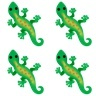

In [7]:
# 元のTensorFlowコード(block%d_conv1)に合わせ、vgg.features内の実際のレイヤーインデックスを指定
STYLE_LAYER_NAMES = {
    "block1_conv1": "0",
    "block2_conv1": "5",
    "block3_conv1": "10",
    "block4_conv1": "17",
    "block5_conv1": "24",
}


class StyleModel:
    def __init__(self):
        # self.vgg は vgg16().features であり、その中のレイヤー名は '0', '1', ... となる
        self.vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features.to(device).eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

        self.layer_outputs = {}
        for name, layer in self.vgg.named_modules():
            # nameが '0', '5', '10' などに一致するかチェックする
            if name in STYLE_LAYER_NAMES.values():
                layer.register_forward_hook(self.get_hook(name))

        # VGG16 normalization
        mean_bgr = torch.tensor([103.939, 116.779, 123.68], device=device).view(
            1, 3, 1, 1
        )

        def preprocess_tf_style(x):
            # xの入力は (N, C, H, W) で、CはRGBの順
            x = x * 255.0
            # RGB -> BGR
            x_bgr = x[:, [2, 1, 0], :, :]
            return x_bgr - mean_bgr

        self.normalize = preprocess_tf_style

    def get_hook(self, name):
        def hook(model, input, output):
            self.layer_outputs[name] = output

        return hook

    def run_model(self, img):
        # Expects (N, H, W, C) float32 [0, 1] tensor
        # Permute to (N, C, H, W)
        self.layer_outputs.clear()  # 念のため実行ごとに出力辞書をクリア
        img = img.permute(0, 3, 1, 2)
        img = self.normalize(img)
        self.vgg(img)
        # STYLE_LAYER_NAMES.values() は ['0', '5', '10', '17', '24'] を返す
        # self.layer_outputs には {'0': tensor, '5': tensor, ...} が格納されている
        return [self.layer_outputs[name] for name in STYLE_LAYER_NAMES.values()]

    def calc_style_content(self, img):
        style_layers = self.run_model(img)
        style = [gram_style(a) for a in style_layers]
        return style, None


# StyleModelのインスタンスを再作成
style_model = StyleModel()


def gram_style(a):
    # a is (N, C, H, W)
    n, c, h, w = a.shape
    a = torch.sqrt(a + 1.0) - 1.0
    features = a.view(n, c, h * w)
    gram = torch.bmm(features, features.transpose(1, 2))
    return gram / (h * w)


def style_loss(a, b):  # a and b are lists of gram matrices
    return sum(torch.mean((x - y) ** 2, dim=[-2, -1]) for x, y in zip(a, b))


style_model = StyleModel()

# @title Inception model (Skipped in PyTorch conversion as it's a bonus and not the main training method)
# The original code provided an InceptionV1 model for an alternative loss.
# This can be implemented using torch.hub or other PyTorch model zoos if needed,
# but for a faithful conversion of the main experiment, we focus on the VGG-based style loss.

model_name = "lizard"
style_img_np = imread("%s_target.jpg" % model_name)
imshow(style_img_np)

# RD system is fully isotropic, so we use a variant of texture loss that
# tries to match input image with rotated versions of the target sample
target_styles = []
for r in np.linspace(0.0, 360, 65)[:-1] + 0.12345:
    img_np = ndimage.rotate(style_img_np, r, reshape=False, mode="wrap")
    img_torch = torch.from_numpy(img_np[None, ...]).to(device)
    style, _ = style_model.calc_style_content(img_torch)
    target_styles.append([s.detach() for s in style])
imwrite("%s.jpg" % model_name, style_img_np)

In [8]:
def style_loss_f(x):
    # x is a torch tensor (N, H, W, C)

    # to_rgb(x) を呼び出す代わりに、テンソルのまま処理を行う
    # これにより、NumPy配列への不要な変換を回避する
    imgs = x[..., :3] + 0.5

    # style_modelにはPyTorchテンソルが渡される
    gs, _ = style_model.calc_style_content(imgs)

    sl = torch.full([x.shape[0]], float("inf"), device=device)
    for ts in target_styles:
        # tsはCPUにある可能性があるため、GPUに転送する
        ts_batch = [s.to(device).repeat(x.shape[0], 1, 1) for s in ts]
        sl = torch.min(sl, style_loss(gs, ts_batch))
    return torch.mean(sl)

# 学習

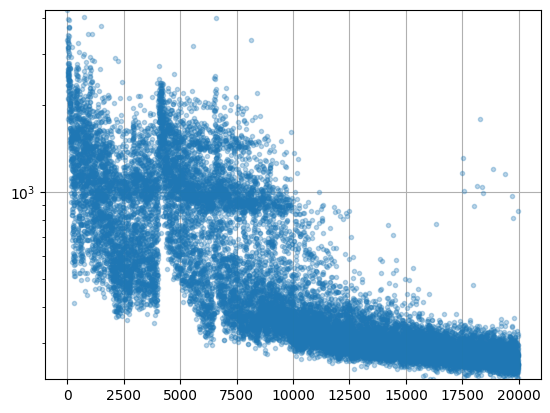

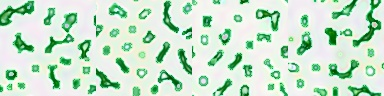

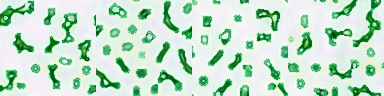

Step: 19985, Loss: 252.114441, LR: 5.0e-05

 96%|█████████▋| 231/240 [00:04<00:00, 16.53it/s] /tmp/ipykernel_5350/3085821795.py:73: RuntimeWarning: invalid value encountered in cast
  img = np.uint8(img.clip(0, 1)*255)
100%|██████████| 240/240 [00:05<00:00, 45.77it/s]


In [ ]:
# @title Setup training
ca = CA().to(device)
cpm_NN = CPM_NN().to(device)
loss_log = []

# PyTorch equivalent of PiecewiseConstantDecay
optimizer = optim.Adam(ca.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000, 10000], gamma=0.2)

pool = seed_f(1024)


def train_step(x0_np):
    """32~128回のforwardの後、学習を1ステップ実行する関数"""
    x = torch.from_numpy(x0_np).to(device)

    optimizer.zero_grad()

    step_n = torch.randint(32, 128, ()).item()
    for i in range(step_n):
        x = ca(x)

    loss = style_loss_f(x)
    loss.backward()

    # Faithful implementation of the original gradient normalization
    with torch.no_grad():
        for p in ca.parameters():
            if p.grad is not None:
                p.grad /= torch.norm(p.grad) + 1e-8

    optimizer.step()

    return loss.item(), x.detach().cpu().numpy()


# @title Training loop {vertical-output: true}
for i in range(20000):
    # --- ここから修正 ---
    # TensorFlowのPiecewiseConstantDecayの挙動を再現
    if i < 1000:
        lr = 1e-3
    elif i < 10000:
        lr = 2e-4
    else:
        lr = 5e-5

    # オプティマイザの学習率を更新
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    # --- ここまで修正 ---

    batch_idx = np.random.choice(len(pool), 4, replace=False)
    x0 = pool[batch_idx] # 4つのランダムな初期状態を選択
    if i % 32 == 0:  
        x0[:1] = seed_f(1) # 時々初期化を行う

    loss, x_final = train_step(x0) # 32~128回のforwardを実行し、学習を1ステップ実行
    pool[batch_idx] = x_final

    loss_log.append(loss)
    # scheduler.step()

    if i % 16 == 0:
        clear_output(True)
        pl.plot(loss_log, ".", alpha=0.3)
        if np.min(loss_log) > 0.0:
            pl.yscale("log")
        pl.ylim(np.min(loss_log), loss_log[0] if loss_log else 1.0)
        pl.grid()
        pl.show()
        imshow(np.hstack(to_rgb(x0)))
        imshow(np.hstack(to_rgb(x_final)))
        print(
            f'\rStep: {len(loss_log)}, Loss: {loss:.6f}, LR: {optimizer.param_groups[0]["lr"]:.1e}',
            end="",
        )

    if (i + 1) % 1000 == 0:
        # Note: Saving in PyTorch format. Original TF models are not compatible.
        torch.save(ca.state_dict(), f"../results/{model_name}_{len(loss_log):05d}.pth")

# 結果

In [10]:
# @title Model behavior video {vertical-output: true}
# NOTE: Assumes a trained 'ca' model is in memory
with VideoWriter() as vid:
    x_np = seed_f(1, 256)
    x = torch.from_numpy(x_np).to(device)
    for i in tqdm.trange(30 * 8):
        step_n = min(int(2 ** (i / 30.0)), 200)
        with torch.no_grad():
            for _ in range(step_n):
                x = ca(x, r=0.5)
        frame = to_rgb(x.cpu().numpy())[0]
        vid.add(zoom(frame, 2))

 96%|█████████▌| 230/240 [00:04<00:00, 17.19it/s] /tmp/ipykernel_5350/3085821795.py:73: RuntimeWarning: invalid value encountered in cast
  img = np.uint8(img.clip(0, 1)*255)
100%|██████████| 240/240 [00:04<00:00, 50.31it/s]
